In [1]:
import pandas as pd
import numpy as np
import math
from struct import *
import base64
import matplotlib.pyplot as plt

In [129]:
#cap_data = pd.read_csv('Abhi_Initial_Verify_Data/Data 2022-03-18 152205.csv',header=None)
cap_data = pd.read_csv('Abhi_Initial_Verify_Data/Data 2022-03-28 180937.csv',header=None)

##**Decode header and sort by type into independent dataframes**

In [130]:
def decodeString(input):
  return base64.b64decode(input)

#   C DEFINITION
#
# typedef struct PacketHeaders{
#   uint16_t packetType;
#   uint16_t packetID;
#   uint32_t msFromStart;
#   uint32_t epoch;
#   uint32_t payloadLength;
#   uint32_t reserved[5];
# }PacketHeader;

headerTypes = "HHIIIIIIII"
size_of_header = calcsize(headerTypes)
headerLabels = ["packetType","packetID","msFromStart","epoch","payloadLength","res0","res1","res2","res3", "res4"]
def decodeHeader(input):
  packetType, packetID, msFromStart, epoch, payloadLength, res0, res1, res2, res3, res4 = unpack(headerTypes,input[:size_of_header])
  return packetType, packetID, msFromStart, epoch, payloadLength, res0, res1, res2, res3, res4

In [131]:
cap_data["decoded"] = cap_data[1].apply(decodeString)

In [132]:
cap_data["decoded_header"]=cap_data["decoded"].apply(decodeHeader)
cap_header_data = cap_data["decoded_header"].apply(pd.Series)
cap_header_data.columns = headerLabels
cap_data = cap_data.join(cap_header_data)
cap_data.head()

,0,1,decoded,decoded_header,packetType,packetID,msFromStart,epoch,payloadLength,res0,res1,res2,res3,res4
0,2022-03-28 18:09:39,BQB4AMq2AAAAAAAAkAEAAAAAAAAAAAAAAAAAAAAAAAAAAA...,b'\x05\x00x\x00\xca\xb6\x00\x00\x00\x00\x00\x0...,"(5, 120, 46794, 0, 400, 0, 0, 0, 0, 0)",5,120,46794,0,400,0,0,0,0,0
1,2022-03-28 18:09:39,BQB5AFq4AAAAAAAAkAEAAAAAAAAAAAAAAAAAAAAAAAAAAA...,b'\x05\x00y\x00Z\xb8\x00\x00\x00\x00\x00\x00\x...,"(5, 121, 47194, 0, 400, 0, 0, 0, 0, 0)",5,121,47194,0,400,0,0,0,0,0
2,2022-03-28 18:09:39,BQB6ACK5AAAAAAAAyAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,"b'\x05\x00z\x00""\xb9\x00\x00\x00\x00\x00\x00\x...","(5, 122, 47394, 0, 200, 0, 0, 0, 0, 0)",5,122,47394,0,200,0,0,0,0,0
3,2022-03-28 18:09:39,BQB7ALK6AAAAAAAAkAEAAAAAAAAAAAAAAAAAAAAAAAAAAA...,b'\x05\x00{\x00\xb2\xba\x00\x00\x00\x00\x00\x0...,"(5, 123, 47794, 0, 400, 0, 0, 0, 0, 0)",5,123,47794,0,400,0,0,0,0,0
4,2022-03-28 18:09:39,BQB8AEK8AAAAAAAAkAEAAAAAAAAAAAAAAAAAAAAAAAAAAA...,b'\x05\x00|\x00B\xbc\x00\x00\x00\x00\x00\x00\x...,"(5, 124, 48194, 0, 400, 0, 0, 0, 0, 0)",5,124,48194,0,400,0,0,0,0,0


**Packet Types are as follows**
5.   BLINK
6.   THERMAL
7.   ACCELEROMETER
8.   MAGNETOMETER
9.   GYROSCOPE

In [133]:
raw_blink_df = cap_data[cap_data["packetType"] == 5].reset_index(drop=True)
raw_thermal_df = cap_data[cap_data["packetType"] == 6].reset_index(drop=True)
raw_acc_df = cap_data[cap_data["packetType"] == 7].reset_index(drop=True)
raw_gyro_df = cap_data[cap_data["packetType"] == 9].reset_index(drop=True)

l_blink = len(raw_blink_df)
l_thermal = len(raw_thermal_df)
l_acc = len(raw_acc_df)
l_gyro = len(raw_gyro_df)

print("Blink entries:\t" + str(l_blink))
print("Thermal entries:\t" + str(l_thermal))
print("Accel entries:\t" + str(l_acc))
print("Gyro entries:\t" + str(l_gyro))

Blink entries:	726
Thermal entries:	61
Accel entries:	0
Gyro entries:	0


In [134]:
#drop duplicates:
raw_blink_df.drop_duplicates(inplace=True)
raw_thermal_df.drop_duplicates(inplace=True)
raw_acc_df.drop_duplicates(inplace=True)
raw_gyro_df.drop_duplicates(inplace=True)

print('compare to above for duplicated packet count!')
print("Blink duplicates:\t" + str(l_blink-len(raw_blink_df)))
print("Thermal duplicates:\t" + str(l_thermal-len(raw_thermal_df)))
print("Accel duplicates:\t" + str(l_acc-len(raw_acc_df)))
print("Gyro duplicates:\t" + str(l_gyro-len(raw_gyro_df)))

compare to above for duplicated packet count!
Blink duplicates:	0
Thermal duplicates:	0
Accel duplicates:	0
Gyro duplicates:	0


In [107]:
raw_blink_df.head()

,0,1,decoded,decoded_header,packetType,packetID,msFromStart,epoch,payloadLength,res0,res1,res2,res3,res4


In [126]:
# for index, row in raw_acc_df.iterrows():
#   print(row["packetID"])

In [127]:
# raw_blink_df.plot(y="packetID")

#for index, row in raw_blink_df.iterrows():
#  print(row["packetID"])
#  print(row)

Check if any packets dropped

In [108]:
def packetID_checker(input_df):
  dropped_packets = 0
  duplicate_packets = 0
  pcktID_idx = 0


  for index, row in input_df.iterrows():
    if index == 0:
      pcktID_idx = row["packetID"]
      continue

    delta = row["packetID"] - pcktID_idx

    if delta > 1:
      dropped_packets += 1
    if delta == 0:
      duplicat_packets += 1
    
    pcktID_idx = row["packetID"]

  return dropped_packets

In [109]:
blink_dropped_packets = packetID_checker(raw_blink_df)
thermal_dropped_packets = packetID_checker(raw_thermal_df)
acc_dropped_packets = packetID_checker(raw_acc_df)
gyro_dropped_packets = packetID_checker(raw_gyro_df)

print("Blink packet dropped rate (%):\t\t " + str(100*blink_dropped_packets/len(raw_blink_df)))
print(" Blink packet count:\t\t\t " + str(len(raw_blink_df)))
print("Thermal packet dropped rate (%):\t " + str(100*thermal_dropped_packets/len(raw_thermal_df)))
print(" Thermal packet count:\t\t\t " + str(len(raw_thermal_df)))
print("Acc packet dropped rate (%):\t\t " + str(100*acc_dropped_packets/len(raw_acc_df)))
print(" Acc packet count:\t\t\t " + str(len(raw_acc_df)))
print("Gyro packet dropped rate (%):\t\t " + str(100*gyro_dropped_packets/len(raw_gyro_df)))
print(" Gyro packet count:\t\t\t " + str(len(raw_gyro_df)))

ZeroDivisionError: division by zero

## **Define the structs for each payload type & parse**

**Blink**

In [146]:
blinkTypes = "B"
size_of_blink = calcsize(blinkTypes)
blinkLabels = ["data"]
blinkSampleRate = 1000 # 1kHz
blinkSamplePeriod_ms = 1000 * (1/blinkSampleRate) # 1 ms

In [147]:
def parseBlink(input_df):
  length_of_payload = input_df["payloadLength"]
  num_of_blink_samples_in_payload = int(length_of_payload/size_of_blink)

  # remove the header prefix
  payload = input_df["decoded"]
  payload = payload[size_of_header:]

  blink_samples = unpack(str(num_of_blink_samples_in_payload)+blinkTypes, payload)
  new_df = pd.DataFrame(blink_samples, columns=["data"])
  new_df["packetID"] = input_df["packetID"]
  new_df["epoch"] = input_df["epoch"] # not used
  new_df["serverTS"] = input_df[0]
  timeStamps = np.arange(input_df["msFromStart"] - num_of_blink_samples_in_payload * blinkSamplePeriod_ms + 1, input_df["msFromStart"] + 1, blinkSamplePeriod_ms)
  new_df["msFromStart"] = timeStamps.astype(int)
  new_df["saturated"] = input_df["res0"] # if 1, the emitter is off because there is too much NIR light in the room which causes sensor to saturate

  return new_df

In [148]:
blink_df = pd.DataFrame()
for index, row in raw_blink_df.iterrows():
  blink_df = blink_df.append(parseBlink(row))

<AxesSubplot:xlabel='msFromStart'>

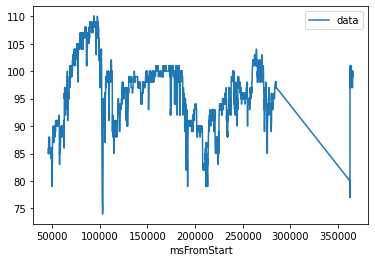

In [149]:
blink_df.plot(x='msFromStart', y="data")

**Accelerometer & Gyroscope**

In [134]:
threeAxisTypes = "hhhII"
size_of_threeAxis = calcsize(threeAxisTypes)
threeAxisLabels = ["x","y","z","imu_tick_ms","tick_ms"]

In [135]:
def parseThreeAxis(input_df):
  length_of_payload = input_df["payloadLength"]
  num_of_three_axis_samples_in_payload = int(length_of_payload/size_of_threeAxis)

  # remove the header prefix
  payload = input_df["decoded"]
  payload = payload[size_of_header:]

  new_df = pd.DataFrame(columns=threeAxisLabels)
  for i in range(num_of_three_axis_samples_in_payload):
    three_axis_samples = unpack(threeAxisTypes, payload[i*size_of_threeAxis:(i+1)*size_of_threeAxis])
    if(three_axis_samples[-1]>=300000000): # an error was found where some samples are corrupted so skipping them
      print("Corrupted sample found:")
      print(three_axis_samples)
      continue 
    df_length = len(new_df)
    new_df.loc[df_length] = three_axis_samples

  new_df["serverTS"] = input_df[0]
  new_df["msFromStart"] = input_df["msFromStart"]
  return new_df

In [136]:
acc_df = pd.DataFrame()
for index, row in raw_acc_df.iterrows():
  acc_df = acc_df.append(parseThreeAxis(row))
acc_df = acc_df.reset_index()

In [137]:
acc_sample_rate = 1000 * len(acc_df) / (acc_df.at[len(acc_df)-1,"tick_ms"] - acc_df.at[0,"tick_ms"])
print("Acc sample rate: " + str(acc_sample_rate))

Acc sample rate: 29.354706963447008


In [138]:
acc_df

,index,x,y,z,imu_tick_ms,tick_ms,serverTS,msFromStart
0,0,2156,-986,651,10,128790,2022-03-18 15:22:06,129610
1,1,2166,-986,660,7,128820,2022-03-18 15:22:06,129610
2,2,2166,-986,680,5,128852,2022-03-18 15:22:06,129610
3,3,2176,-996,680,32,128890,2022-03-18 15:22:06,129610
4,4,2176,-996,680,5,128916,2022-03-18 15:22:06,129610
...,...,...,...,...,...,...,...,...
7470,20,2352,-701,258,5,383308,2022-03-18 15:24:13,383442
7471,21,2352,-692,258,31,383345,2022-03-18 15:24:13,383442
7472,22,2352,-682,249,5,383372,2022-03-18 15:24:13,383442
7473,23,2352,-701,268,10,383405,2022-03-18 15:24:13,383442


<AxesSubplot:xlabel='tick_ms'>

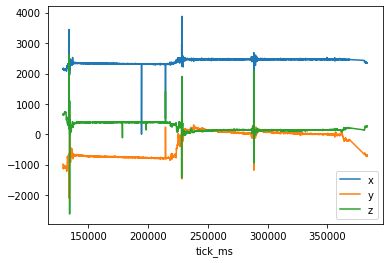

In [139]:
acc_df.plot(x="tick_ms",y=["x","y","z"])

In [140]:
gyro_df = pd.DataFrame()
for index, row in raw_gyro_df.iterrows():
  gyro_df = gyro_df.append(parseThreeAxis(row))
gyro_df = gyro_df.reset_index()

In [141]:
gyro_sample_rate = 1000 * len(gyro_df) / (gyro_df.at[len(gyro_df)-1,"tick_ms"] - gyro_df.at[0,"tick_ms"])
print("Gyro sample rate: " + str(gyro_sample_rate))

Gyro sample rate: 47.03410756700401


In [142]:
gyro_df

,index,x,y,z,imu_tick_ms,tick_ms,serverTS,msFromStart
0,0,12,37,82,23,128924,2022-03-18 15:22:06,129404
1,1,22,31,81,21,128942,2022-03-18 15:22:06,129404
2,2,32,25,80,40,128965,2022-03-18 15:22:06,129404
3,3,37,20,78,25,128983,2022-03-18 15:22:06,129404
4,4,45,13,76,21,129003,2022-03-18 15:22:06,129404
...,...,...,...,...,...,...,...,...
11995,20,-2,-5,-3,25,383978,2022-03-18 15:24:13,384068
11996,21,-1,-3,-3,21,383996,2022-03-18 15:24:13,384068
11997,22,0,-4,-3,25,384018,2022-03-18 15:24:13,384068
11998,23,1,-5,-1,23,384037,2022-03-18 15:24:13,384068


<AxesSubplot:xlabel='tick_ms'>

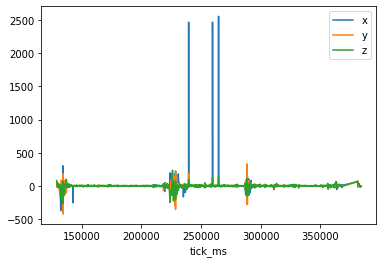

In [143]:
gyro_df.plot(x="tick_ms",y=["x","y","z"])

In [144]:
gyro_df.head()

,index,x,y,z,imu_tick_ms,tick_ms,serverTS,msFromStart
0,0,12,37,82,23,128924,2022-03-18 15:22:06,129404
1,1,22,31,81,21,128942,2022-03-18 15:22:06,129404
2,2,32,25,80,40,128965,2022-03-18 15:22:06,129404
3,3,37,20,78,25,128983,2022-03-18 15:22:06,129404
4,4,45,13,76,21,129003,2022-03-18 15:22:06,129404


In [145]:
gyro_df.iloc[-1]

index                           24
x                                2
y                               -7
z                               -3
imu_tick_ms                     25
tick_ms                     384058
serverTS       2022-03-18 15:24:13
msFromStart                 384068
Name: 11999, dtype: object

**Thermal** (use secondary processor tick_ms because thats the most accurate for each sample but I did do some interpolation for tick_ms to roughly sync up)

In [135]:
# struct thermopileData {
# 	uint16_t thermopile;
# 	uint16_t thermistor;
# 	uint32_t tick_ms;
# };

# struct thermopilePackagedData {
# 	struct thermopileData temple[5];
# 	struct thermopileData nose[5];
# };

# struct secondaryProcessorData {
# 	struct thermopilePackagedData temp;
# 	uint32_t tick_ms;
# 	uint32_t epoch;
# };

tempTypes = "HHI"
tempSuffixTypes = "II"
tempPacketType = tempTypes * 5 + tempTypes * 5 + tempSuffixTypes
size_of_tempPacketType = calcsize(tempPacketType)
tempLabels = ["temple_tp","temple_thermistor","secondary_temple_tick_ms","nose_tp","nose_thermistor","secondary_nose_tick_ms","tick_ms","epoch"]
tempSuffixLabels = ["tick_ms","epoch"]
tempSamplePeriod_ms = 100



In [136]:
def flatten(t):
  return [item for sublist in t for item in sublist]

def parseThermal(input_df):
  length_of_payload = input_df["payloadLength"]
  num_of_thermal_samples_in_payload = int(length_of_payload/size_of_tempPacketType)

  # remove the header prefix
  payload = input_df["decoded"]
  payload = payload[size_of_header:]

  corePacketLength = 6

  new_df = pd.DataFrame(columns=tempLabels)
  indicies = np.array([0,1,2,3,4,5,6,7])

  for i in range(num_of_thermal_samples_in_payload):
    thermal_samples = np.array(unpack(tempPacketType, payload[i*size_of_tempPacketType:i*size_of_tempPacketType+size_of_tempPacketType]))
    thermal_samples_temp = []
    for j in range(5):
      thermal_samples_temp.append(thermal_samples[(j*3):(j*3+3)])
      thermal_samples_temp.append(thermal_samples[(15+j*3):(15+j*3+3)])

    thermal_samples_temp.append(thermal_samples[-2:])
    thermal_samples = np.array(flatten(thermal_samples_temp))
    # thermal_samples_temp.flatten()

    for j in range(5):
      df_length = len(new_df)
      new_indicie = indicies + corePacketLength * j
      new_indicie[-2] = -2
      new_indicie[-1] = -1
      new_df.loc[df_length] = thermal_samples[new_indicie]
      new_df.at[df_length,"tick_ms"] = new_df.at[df_length,"tick_ms"] - (4-j) * tempSamplePeriod_ms

  new_df["serverTS"] = input_df[0]

  return(new_df)

In [138]:
thermal_df = pd.DataFrame()
for index, row in raw_thermal_df.iterrows():
  thermal_df = thermal_df.append(parseThermal(row))

<AxesSubplot:xlabel='tick_ms'>

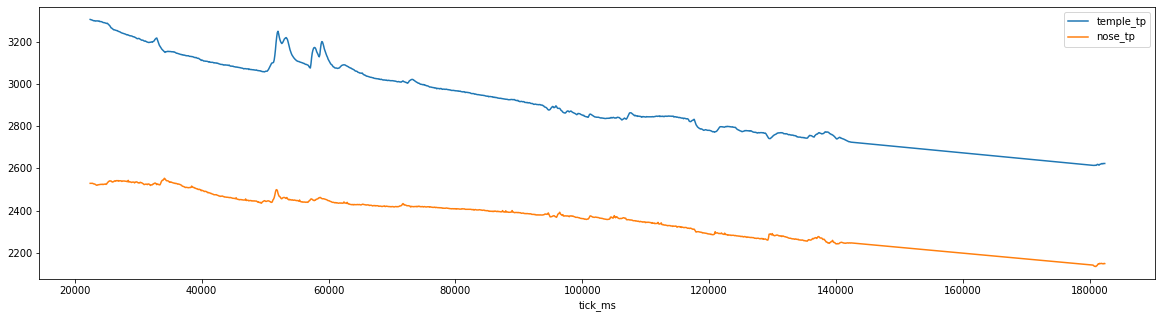

In [161]:
fig, ax = plt.subplots(figsize=(20,5))
thermal_df.plot(x="tick_ms",y="temple_tp", ax=ax)
thermal_df.plot(x="tick_ms",y="nose_tp", ax=ax)

<AxesSubplot:xlabel='tick_ms'>

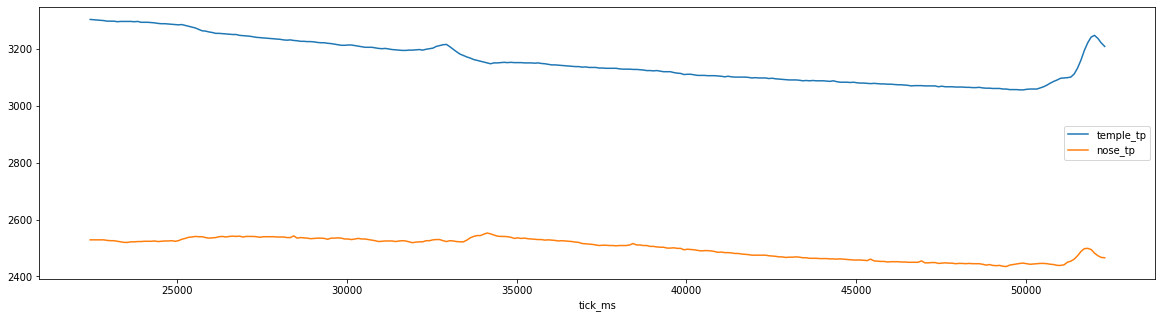

In [162]:
fig, ax = plt.subplots(figsize=(20,5))
thermal_df.iloc[0:300].plot(x="tick_ms",y="temple_tp", ax=ax)
thermal_df.iloc[0:300].plot(x="tick_ms",y="nose_tp", ax=ax)

<AxesSubplot:xlabel='tick_ms'>

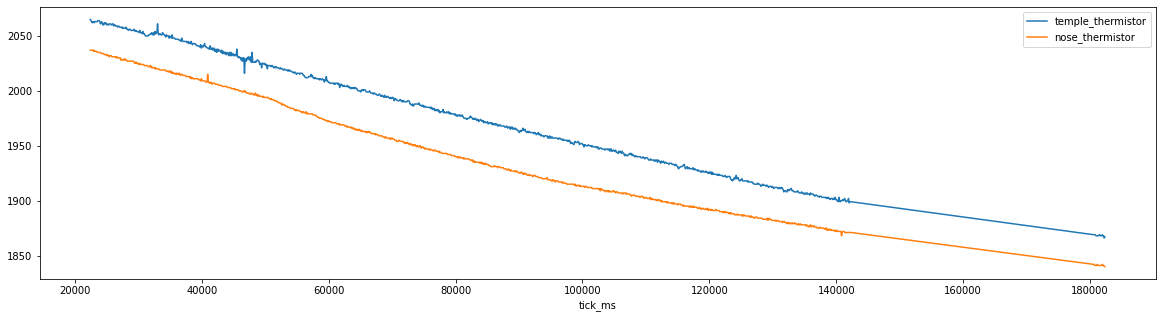

In [163]:
fig, ax = plt.subplots(figsize=(20,5))
thermal_df.plot(x="tick_ms",y="temple_thermistor", ax=ax)
thermal_df.plot(x="tick_ms",y="nose_thermistor", ax=ax)

## **Data Analysis Pipeline**

---



# Thermal

from our lovely paper:

- T_obj = fourth root (T_ref^4 + f{V_tp}/A)
- f{V_tp} = (V_tp - a_0) + a_1*(V_tp - a_0)^2

- A_nose = 7.8e-10, a_0_nose = -2.31e-01, a_1_nose = 3.61e-03

- A_tpl = 4.21e-10, a_0_tpl = -3.62e-01, a_1_tpl = 8.31e-02

T_ref is based on the thermistor value.  
- The thermistors form a voltage divider -- 3.3V - 100k - THERMISTOR - GND
- this feeds into the 12bit ADC with no gain.  (0-4095)
- The data sheet tells us the appropriate temperature for a resistance; use Beta and Kelvin

Raw thermistor ADC_val to R_thermistor to Kelvin:

- ADC_val to voltage: ADC_val = (V_out / 3.3V) * 4095
- voltage to R_thermistor: V_out = R_thermistor / (100k+R_thermistor) * 3.3V
- R_thermistor to temp K: (from thermistor datasheet): 100k at 25 deg C or 298.15 K (+ 273.15); Beta = 3960


V_thermopile is around 10mV -- goes through LMP91051 front end, which is AC coupled and biased to 1.15V, with gain of 1000 -- then into our into 12-bit ADC (centered at 1.15V).

Be careful, DAC config 0x1 for the LMP is also set currently to shift output -33.8mV * (n-128), so we have an additional shift up on the output of 0.6084V

Raw thermopile ADC_val to V_thermopile:
- ADC_val to voltage: V_out = (ADC_val / 4095) * 3.3
- Voltage to thermopile voltage: V_therm = (V_out - 1.15)/1000.0

In [152]:
def convert_thermistor_to_K(raw_value):
    # STEP 1. Calc R_thermistor value given ADC_val
    R_divider = 100000
    ADC_max = 4095
    
    R_t = (R_divider * raw_value/ADC_max) / (1 - raw_value/ADC_max)
    
    # STEP 2. Convert R_t to temp
    R_0 = 100000
    T_0 = 298.15
    Beta = 3960
    R_inf = R_0 * math.exp(-Beta/T_0)
    
    Temp_K = Beta / np.log(R_t / R_inf)
    return Temp_K
    
def convert_thermopile_to_C(raw_val, T_ref_K, A, a_0, a_1):
    #STEP 1. Calc V_thermopile based on preamp gain and bias
    V_tp = (((raw_val / 4095) * 3.3) - (1.15+0.6084))/1000.0
    
    #STEP 2. Solve for Temperature!
    f_V_tp = (V_tp - a_0) + a_1 * (V_tp - a_0)**2
    T_obj = (T_ref_K**4 + f_V_tp/A)**0.25
    return (T_obj - 273.15)
    
def convert_nose_temp(raw_val, raw_thermistor):
    A   =  7.8e-10
    a_0 = -2.31e-01
    a_1 =  3.61e-03
    return convert_thermopile_to_C(raw_val, 
                                  convert_thermistor_to_K(raw_thermistor), 
                                  A, a_0, a_1)
    
def convert_temple_temp(raw_val, raw_thermistor):
    A   =  4.21e-10
    a_0 = -3.62e-01
    a_1 =  8.31e-02
    return convert_thermopile_to_C(raw_val, 
                                  convert_thermistor_to_K(raw_thermistor), 
                                  A, a_0, a_1)

In [153]:
thermal_df['nose_temp_C'] = thermal_df.apply(lambda x: convert_nose_temp(x['nose_tp'], x['nose_thermistor']), axis=1)
thermal_df['temple_temp_C'] = thermal_df.apply(lambda x: convert_temple_temp(x['temple_tp'], x['temple_thermistor']), axis=1)

<AxesSubplot:xlabel='tick_ms'>

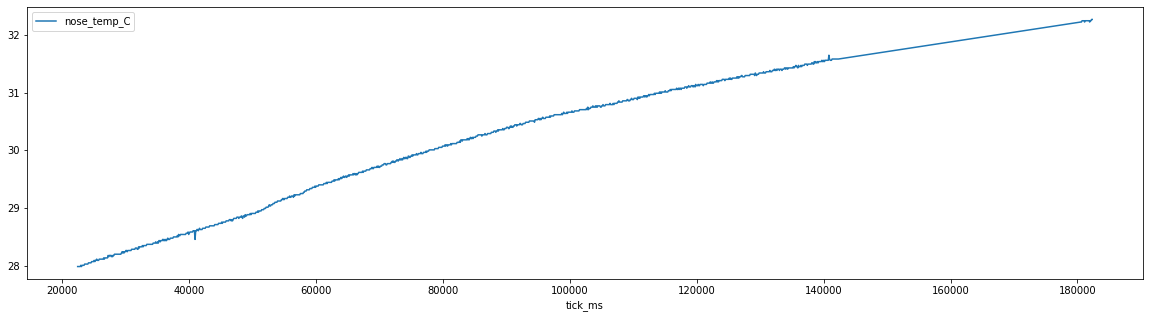

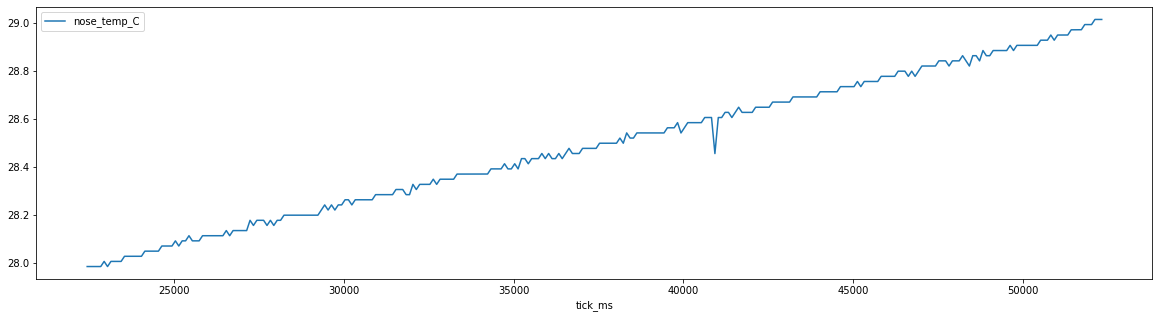

In [157]:
fig, ax = plt.subplots(figsize=(20,5))  
thermal_df.plot(x="tick_ms",y="nose_temp_C", ax=ax)

fig, ax = plt.subplots(figsize=(20,5))  
thermal_df.iloc[0:300].plot(x="tick_ms",y="nose_temp_C", ax=ax)

<AxesSubplot:xlabel='tick_ms'>

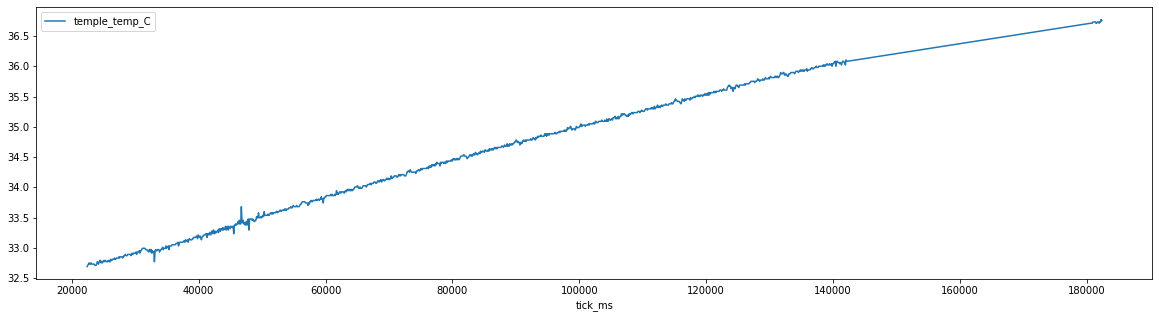

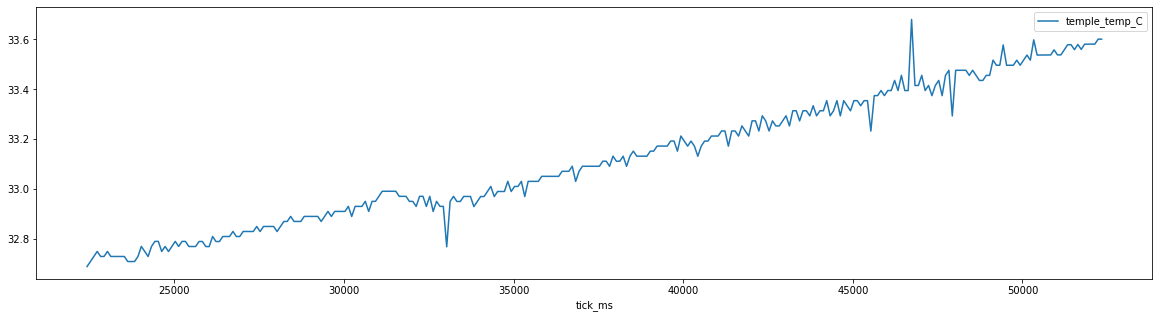

In [158]:
fig, ax = plt.subplots(figsize=(20,5))  
thermal_df.plot(x="tick_ms",y="temple_temp_C", ax=ax)

fig, ax = plt.subplots(figsize=(20,5))  
thermal_df.iloc[0:300].plot(x="tick_ms",y="temple_temp_C", ax=ax)

<AxesSubplot:xlabel='tick_ms'>

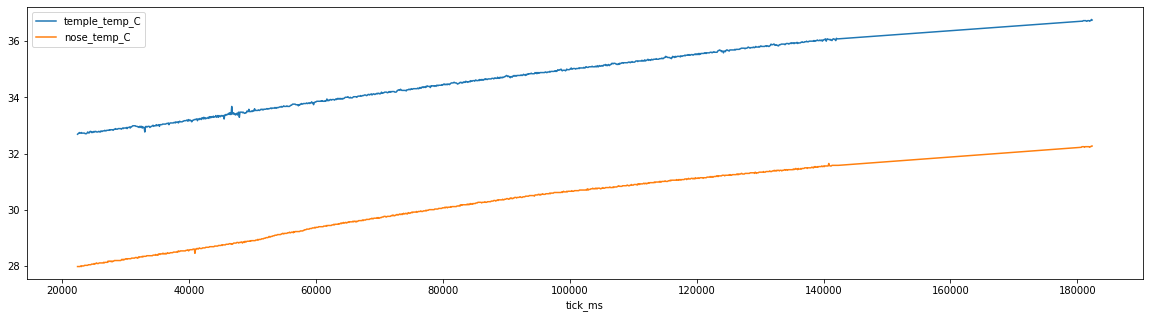

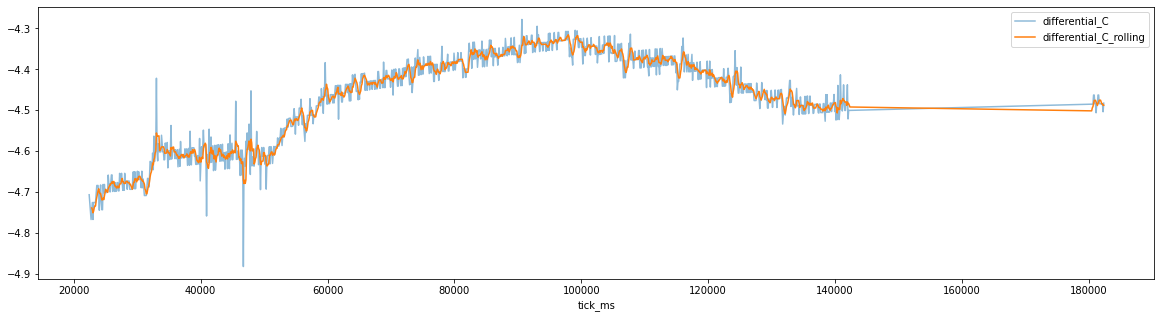

In [168]:
thermal_df['differential_C'] = thermal_df['nose_temp_C'] - thermal_df['temple_temp_C']
thermal_df['differential_C_rolling'] = thermal_df['differential_C'].rolling(5).mean()

fig, ax = plt.subplots(figsize=(20,5)) 
thermal_df.plot(x="tick_ms",y="temple_temp_C", ax=ax)
thermal_df.plot(x="tick_ms",y="nose_temp_C", ax=ax)

fig, ax = plt.subplots(figsize=(20,5)) 
thermal_df.plot(x="tick_ms",y="differential_C", ax=ax, alpha=0.5)
thermal_df.plot(x="tick_ms",y="differential_C_rolling", ax=ax)

# Blink Processing

In [159]:
print(blink_df.columns)

#pd.set_option('display.max_rows', 500)
#blink_df.loc[blink_df['msFromStart']> 327000].head(500)

Index(['data', 'packetID', 'epoch', 'serverTS', 'msFromStart', 'saturated'], dtype='object')


In [160]:
def grab_blinks(blink_sess, thresh=0.06, blink_dur_ms=175, lpf_samples=50, dx_lpf_samples=25, reverse=False, plot=True, xlims=None):
    #get array of (1)timestamps of blinks, (2) [peak close velocity, peak open velocity], (3) duration
    
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'same') / w
    
    blink_sess = blink_sess.sort_values(by=['msFromStart'], ascending=True)

    #step 1: LPF input, take derivative, LPF derivative
    smooth_input = moving_average(blink_sess['data'], lpf_samples)
    dx = np.append([np.nan], np.diff(smooth_input))
    smooth_dx = moving_average(dx, dx_lpf_samples)
    df_results = pd.DataFrame({'timestamp_ms':blink_sess['msFromStart'], 'dx':smooth_dx})
        
    #step 2, apply threshold
    if reverse:
        decision = (smooth_dx > thresh)
    else:
        decision = (smooth_dx < -1*thresh)

    #step 3, use this thresholded value to decide if we are blinking subject to debounce.
    #grab the blink time. within the bounds of the blink, find the duration and peak velocities using the derivative.
    df_blinks = pd.DataFrame()
    samples_per_blink = int(blink_dur_ms)  # happen to sample at 1kHz so 1 sample == 1 ms
    samples_blink_debounce = int(samples_per_blink/4)
    i, blinkrow = 0, {}
    while i<len(decision):
        if decision[i]: #we have a blink
            blinkrow['timestamp_ms'] = df_results['timestamp_ms'].iloc[i] #timestamp of this blink
            
            df_thisblink = df_results.iloc[i:i+samples_per_blink] #grab the data associated with this blink
            df_thisblink.reset_index(inplace=True)
            
            if reverse:
                max_open  = df_thisblink[df_thisblink['dx'] == df_thisblink['dx'].min()]
                max_close = df_thisblink[df_thisblink['dx'] == df_thisblink['dx'].iloc[0:max_open.index[-1]].max()]
            else:
                max_open  = df_thisblink[df_thisblink['dx'] == df_thisblink['dx'].max()]
                max_close = df_thisblink[df_thisblink['dx'] == df_thisblink['dx'].iloc[0:max_open.index[-1]].min()]
            try:
                blinkrow['close_time'] = max_close['timestamp_ms'].iloc[0]
                blinkrow['open_time'] = max_open['timestamp_ms'].iloc[-1]
                blinkrow['vel_close'] = abs(max_close['dx'].iloc[0]) #peak close velocity
                blinkrow['vel_open']  = abs(max_open['dx'].iloc[-1]) #peak open velocity
                blinkrow['duration_ms'] = max_open['timestamp_ms'].iloc[-1] - max_close['timestamp_ms'].iloc[0] #duration
 
                df_blinks = df_blinks.append(blinkrow, ignore_index=True)
            
            except:
                print('failed to add blink from data at timestamp ', blinkrow['timestamp_ms'])

            
            i += max(max_open.index[-1], samples_blink_debounce)  #move ahead to end of blink, or blink_dur/4, whichever is longer
            
        else: i += 1
            
    if plot:
        fig, ax = plt.subplots(2,1, figsize=(20,10)) 
        blink_sess.plot(x="msFromStart",y="data",ax=ax[0])
        for i,r in df_blinks.iterrows():
            ax[1].plot([r['timestamp_ms'], r['timestamp_ms']],[-5, 5], color='purple', alpha=0.5)
            #ax[1].plot([r['timestamp_ms'] + r['duration_ms'], r['timestamp_ms'] + r['duration_ms']], [-5, 5], color='purple', alpha=0.1)
            ax[1].plot([r['close_time'], r['close_time']],[-5, 5], color='green', alpha=0.2)
            ax[1].plot([r['open_time'], r['open_time']],[-5, 5], color='red', alpha=0.2)
            
        df_results.plot(x="timestamp_ms",y="dx",ax=ax[1], color='orange')
        ax[1].set_ylim(df_results['dx'].min(), df_results['dx'].max())   
        
        if xlims is not None:
            ax[0].set_xlim(xlims)
            ax[1].set_xlim(xlims)
            
    return df_blinks


failed to add blink from data at timestamp  383091
    close_time  duration_ms  open_time  timestamp_ms  vel_close  vel_open
0     139354.0        131.0   139485.0      139335.0     0.0736    0.0368
1     147697.0        143.0   147840.0      147666.0     0.0920    0.0416
2     148515.0        151.0   148666.0      148492.0     0.0952    0.0248
3     150192.0        125.0   150317.0      150166.0     0.0968    0.0376
4     152558.0        136.0   152694.0      152532.0     0.0776    0.0352
5     152908.0         55.0   152963.0      152880.0     0.8192    0.5528
6     153003.0        103.0   153106.0      152976.0     0.8600    0.8312
7     160097.0        133.0   160230.0      160078.0     0.0760    0.0192
8     162136.0        154.0   162290.0      162118.0     0.0824    0.0304
9     175541.0        124.0   175665.0      175525.0     0.0800    0.0368
10    181587.0        159.0   181746.0      181572.0     0.0712    0.0264
11    195711.0        115.0   195826.0      195685.0     0.10

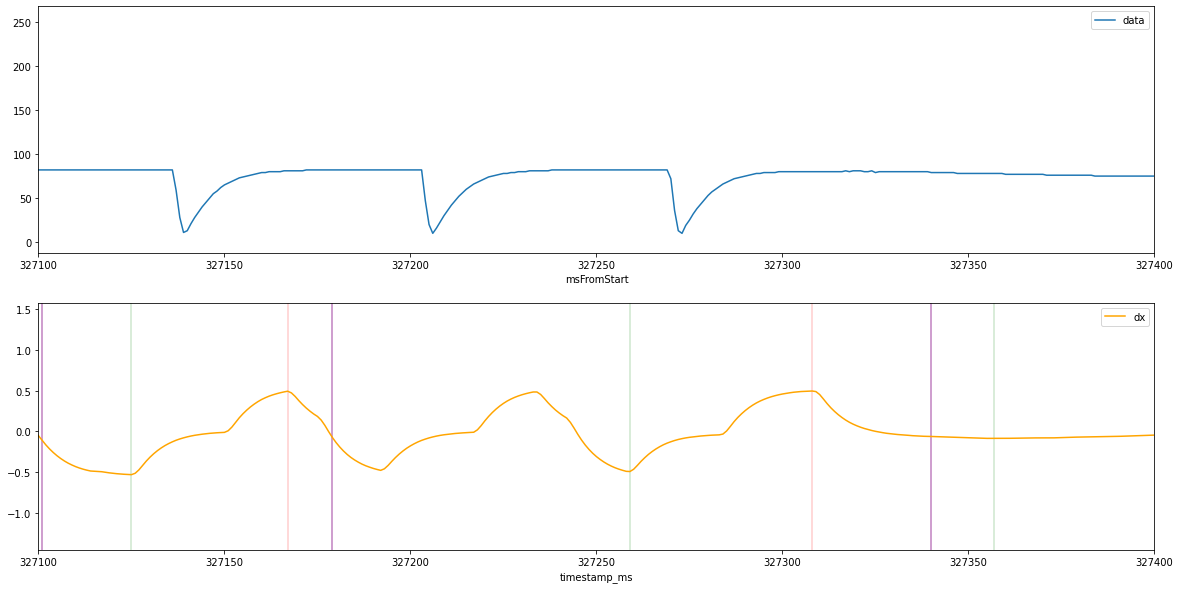

In [161]:
r = grab_blinks(blink_df, xlims=[ 327100, 327400])
print(r)

In [165]:
#the above can be tuned with threshold and blink_duration (max duration to search)
#for an 'auto-threshold' based on user data, we can do the below:

def auto_determine_threshold(blink_df, est_blink_per_min=60, reverse=False, average_num=5, lower_bound_thresh_step=0.001):
    #pass in a raw blink_df that has at least average_num blinks in it.  It will run and identify 
    
    #In our initial test, we had between 10 and 60 blinks per minute
    #therefore we want to grab ~secs+5 'blinks'
    target_blinks = int((blink_df.iloc[-1]['msFromStart'] - blink_df.iloc[0]['msFromStart']) / (1000)*(est_blink_per_min/60) + 5)
    print('want to grab ', target_blinks)
    
    #GRAB BLINKs at 0.05
    best_thresh = 0.05
    current_thresh = 0.05
    best_distance = 1000
    current_distance = 1001
    
    for i in range(1000):
        df_glasses_blinks = grab_blinks(blink_df, thresh=current_thresh, blink_dur_ms=175, reverse=reverse, plot=False)
        print('...got ', len(df_glasses_blinks), ' blinks at ', current_thresh)
        current_distance = abs(target_blinks - len(df_glasses_blinks))
        
        if current_distance <= best_distance:
            best_distance = current_distance
            best_thresh = current_thresh
            if target_blinks > len(df_glasses_blinks):
                current_thresh -= lower_bound_thresh_step
            else:
                current_thresh += lower_bound_thresh_step
        else: 
            if current_distance == 0: #hit it perfectly
                best_thresh = current_thresh
            break
    #finished
    print('DONE after ', i, ' iterations. Using threshold ', current_thresh)
    
    df_glasses_blinks = grab_blinks(blink_df, thresh=best_thresh, blink_dur_ms=175, reverse=reverse, plot=False)
    print('...got ', len(df_glasses_blinks), ' blinks at ', current_thresh)
        
    #get first 100 vel_closed, sorted
    first_velocities = sorted(df_glasses_blinks['vel_close'].iloc[:target_blinks].tolist())
    #assume the 5 most powerful are blinks, and the 5 least are not
    not_blink = sum(first_velocities[:average_num])/average_num
    blink = sum(first_velocities[-average_num:])/average_num
    #set threshold accordingly
    thresh = not_blink + (blink-not_blink)/4
    print('THRESHOLD: ', thresh)
    return thresh

thresh = auto_determine_threshold(blink_df, est_blink_per_min=30)

want to grab  132
failed to add blink from data at timestamp  383091
...got  42  blinks at  0.05
failed to add blink from data at timestamp  383091
...got  43  blinks at  0.049
failed to add blink from data at timestamp  383091
...got  43  blinks at  0.048
failed to add blink from data at timestamp  383091
...got  43  blinks at  0.047
failed to add blink from data at timestamp  383091
...got  43  blinks at  0.046
failed to add blink from data at timestamp  383091
...got  44  blinks at  0.045
failed to add blink from data at timestamp  383091
...got  46  blinks at  0.044
failed to add blink from data at timestamp  383091
...got  47  blinks at  0.043
failed to add blink from data at timestamp  383091
...got  47  blinks at  0.041999999999999996
failed to add blink from data at timestamp  383091
...got  47  blinks at  0.040999999999999995
failed to add blink from data at timestamp  383091
...got  53  blinks at  0.039999999999999994
failed to add blink from data at timestamp  383091
...got 

failed to add blink from data at timestamp  383093
    close_time  duration_ms  open_time  timestamp_ms  vel_close  vel_open
0     152908.0         55.0   152963.0      152888.0     0.8192    0.5528
1     153003.0        103.0   153106.0      152981.0     0.8600    0.8312
2     295134.0        108.0   295242.0      295104.0     0.5248    0.4904
3     295267.0         50.0   295317.0      295257.0     0.4824    0.5312
4     303130.0        108.0   303238.0      303107.0     0.5160    0.4816
5     303263.0         50.0   303313.0      303253.0     0.4728    0.5160
6     311130.0        108.0   311238.0      311097.0     0.5344    0.4992
7     311263.0         50.0   311313.0      311253.0     0.4824    0.5384
8     319130.0        109.0   319239.0      319113.0     0.5224    0.4912
9     319264.0         50.0   319314.0      319253.0     0.4808    0.5128
10    327125.0         42.0   327167.0      327103.0     0.5304    0.4944
11    327259.0         49.0   327308.0      327181.0     0.49

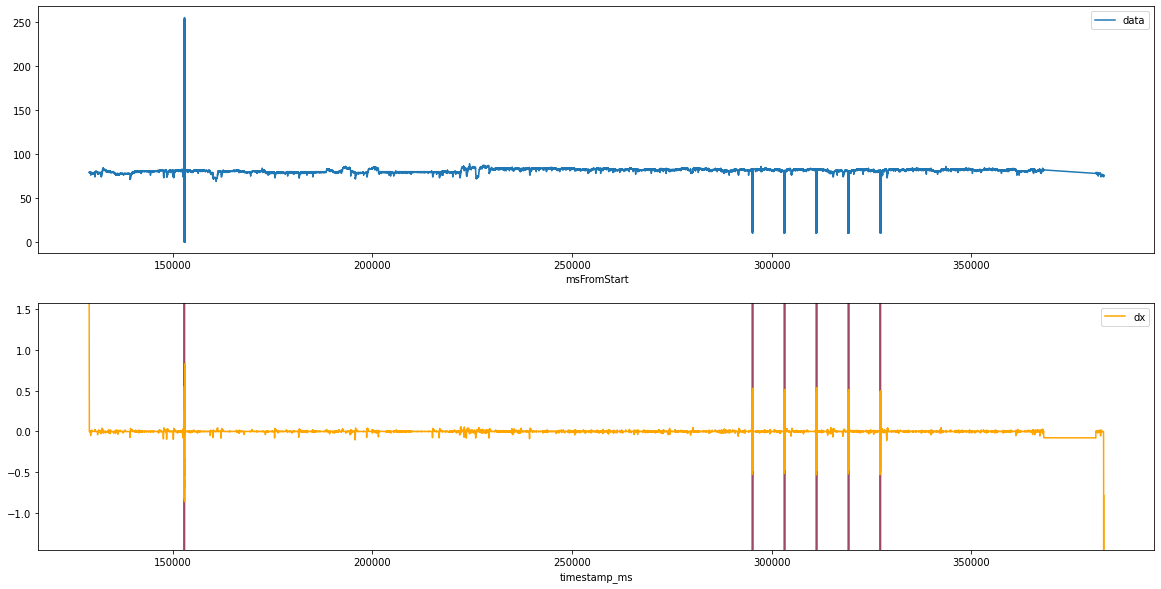

In [166]:
r = grab_blinks(blink_df, thresh=thresh)
print(r)